### Hello Everyone, In this project the flower classification is done with the help of ReduceLROnPlateau 

In [57]:
import numpy as np                                                ###Importing the relevant libraries
import matplotlib.pyplot as plt
import os 
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from sklearn.metrics import classification_report, confusion_matrix

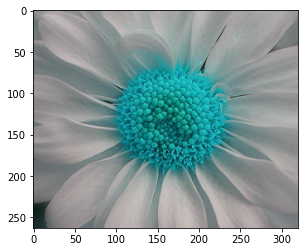

In [2]:
DATADIR = r"C:\Users\KIIT\Downloads\my projects\Deep Learning\Flower Classification\flower_photos"   
CATEGORIES = ["daisy","dandelion","roses","sunflowers","tulips"]

for category in CATEGORIES:                                                              
    path = os.path.join(DATADIR,category)                        ###Directing the path of images and plotting the sample
    for img in os.listdir(path):
        im_array = cv2.imread(os.path.join(path,img))
        plt.imshow(im_array)
        plt.show
        break
    break

In [3]:
im_array.shape

(263, 320, 3)

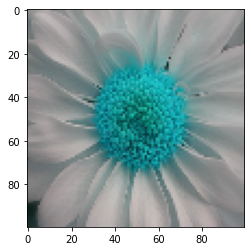

In [4]:
IMG_SIZE = 100

new_array = cv2.resize(im_array, (IMG_SIZE, IMG_SIZE))               ###Resizing the image according to the GPU
plt.imshow(new_array, cmap='gray')
plt.show()

In [5]:
new_array.shape

(100, 100, 3)

In [6]:
data = []

def create_training_data():
    for category in CATEGORIES: 
        path = os.path.join(DATADIR,category)                        ###Creating training data for all 5 classes 
        class_num = CATEGORIES.index(category) 
        for img in tqdm(os.listdir(path)):  
            try:
                img_array = cv2.imread(os.path.join(path,img))  
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE),3) 
                data.append([new_array, class_num])  
            except Exception as e:  
                pass
            

create_training_data()

100%|████████████████████████████████████████████████████████████████████████████████| 799/799 [00:11<00:00, 70.61it/s]


In [7]:
len(data)

3670

In [8]:
import random                                       ###Shuffling the data
random.shuffle(data)

In [9]:
X = []
y = []                                                         ###Dividing it into features and label
for feature,label in data:
    X.append(feature)
    y.append(label)

In [10]:
X = np.array(X)/255                              ###Converting the arrays between 0 and 1
y = np.array(y)

In [11]:
X.shape

(3670, 100, 100, 3)

In [12]:
y.shape

(3670,)

In [13]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)

In [14]:
x_train = x_train.reshape(-1,IMG_SIZE,IMG_SIZE,3)

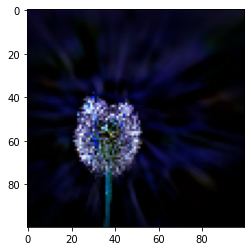

In [16]:
plt.imshow(X[0])

In [18]:
x_test = x_test.reshape(-1,IMG_SIZE,IMG_SIZE,3)              ###Resizing(2)

In [19]:
x_train.shape  

(2752, 100, 100, 3)

In [23]:
y_train

array([0, 1, 1, ..., 0, 1, 1])

In [39]:
from tensorflow.keras.utils import to_categorical

In [40]:
y_train = to_categorical(y_train,5)                      ###Getting shape of (,5) for labels

In [41]:
y_test = to_categorical(y_test,5)

In [42]:
classes = len(np.unique(y))                          

In [43]:
model = Sequential()                     ###Conv2D model
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (100,100,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

In [50]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 100, 100, 32)      2432      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 25, 25, 96)        55392     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 96)      

In [48]:
batch_size=128  ###Using More epochs due to large number of classes
epochs=25

from keras.callbacks import ReduceLROnPlateau   ###Using ReduceLROnPlateau due to the inconsistent dataset
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [45]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [46]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [49]:
model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),epochs = epochs, verbose = 1,validation_data = (x_test,y_test), steps_per_epoch=x_train.shape[0] // batch_size)

<ipython-input-49-a389007dab27>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),epochs = epochs, verbose = 1,validation_data = (x_test,y_test), steps_per_epoch=x_train.shape[0] // batch_size)


Epoch 1/25
21/21 [==============================] - 78s 4s/step - loss: 0.8971 - accuracy: 0.6326 - val_loss: 0.9448 - val_accuracy: 0.6394
Epoch 2/25
21/21 [==============================] - 80s 4s/step - loss: 0.8595 - accuracy: 0.6643 - val_loss: 0.9356 - val_accuracy: 0.6275
Epoch 3/25
21/21 [==============================] - 78s 4s/step - loss: 0.8283 - accuracy: 0.6738 - val_loss: 0.8272 - val_accuracy: 0.6721
Epoch 4/25
21/21 [==============================] - 76s 4s/step - loss: 0.8055 - accuracy: 0.6814 - val_loss: 0.9023 - val_accuracy: 0.6645
Epoch 5/25
21/21 [==============================] - 77s 4s/step - loss: 0.8207 - accuracy: 0.6815 - val_loss: 0.8179 - val_accuracy: 0.6743
Epoch 6/25
21/21 [==============================] - 75s 4s/step - loss: 0.7794 - accuracy: 0.6974 - val_loss: 0.9538 - val_accuracy: 0.6383
Epoch 7/25
21/21 [==============================] - 79s 4s/step - loss: 0.7746 - accuracy: 0.6982 - val_loss: 0.7432 - val_accuracy: 0.7190
Epoch 8/25
21/21 [==

###### After 25 epochs, the accuracy is around 82% which is pretty good considering the type of dataset with incosistent flower images but it can be improved by playing with the hyperparameters

In [51]:
y_pred = model.predict(x_test)

In [52]:
y_pred

array([[1.26153809e-05, 1.59501508e-02, 6.76698377e-03, 9.04882014e-01,
        7.23882467e-02],
       [3.00492356e-05, 1.02694393e-07, 1.03157915e-01, 8.68690336e-07,
        8.96811128e-01],
       [7.84669683e-05, 7.32232138e-07, 2.28356183e-01, 1.27299681e-05,
        7.71551907e-01],
       ...,
       [1.58264628e-03, 3.88200337e-04, 1.32918403e-01, 3.02355940e-04,
        8.64808321e-01],
       [4.76764137e-04, 8.51825971e-05, 1.61844656e-01, 5.82849789e-05,
        8.37535143e-01],
       [9.99993563e-01, 1.01601074e-07, 6.43877684e-07, 5.43622946e-06,
        4.07805885e-07]], dtype=float32)

In [68]:
y_pred_classes = [np.argmax(element) for element in y_pred]                   ###Truncating to integers
Y_test = [np.argmax(y, axis=None, out=None) for y in y_test]
print("Classification Report: \n", classification_report(Y_test, y_pred_classes))         ###Getting the report

Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.71      0.77       140
           1       0.82      0.80      0.81       217
           2       0.68      0.62      0.64       169
           3       0.83      0.91      0.87       172
           4       0.69      0.77      0.73       220

    accuracy                           0.77       918
   macro avg       0.77      0.76      0.76       918
weighted avg       0.77      0.77      0.76       918



In [69]:
y_classes = [np.argmax(element) for element in y_pred]
y_classes[:5]

[3, 4, 4, 3, 4]

In [71]:
Y_test[:5]

[3, 4, 2, 3, 4]

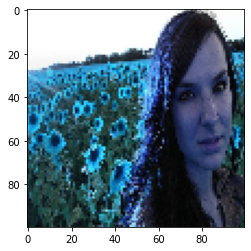

In [72]:
plt.imshow(x_test[0])